### EE 421/521 Image Processing - Spring 2021-22

## Project 6 - Color Theory

#### Submission deadline: 31 March 2022

In this project, you will implement the following:

1. Extract the YUV bands of an image
2. Decimate the Y band and show its effect on the quality of the RGB image
3. Decimate the U band and show its effect on the quality of the RGB image
4. Decimate the V band and show its effect on the quality of the RGB image

**Note: This project will be graded for both EE 421 (HW5) and EE 521 (HW5) students.**

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [1]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# mathematical calculations
import math
import cmath

# DFT calculations
from scipy import fftpack as ft

# histogram calculation
from skimage import exposure

# signal processing operations
from scipy import signal
from scipy.linalg import circulant


In [2]:
# display an image in original size

def my_display_actual_size(img, str_caption):

    height = img.shape[0]
    width = img.shape[1]
    ndim = img.ndim

    isColor = True
    if ndim == 1: isColor=False
    elif ndim != 3: assert False
        
    # determine a figure size big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc.
    margin = 0.05
    dpi = 80
    figsize = (1.0+margin)*height/dpi, (1.0+margin)*width/dpi

    # define the figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # make the axis the right size
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    # display the image
    if isColor:
        ax.imshow(img, interpolation='none')
    else:
        ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.title(str_caption)
    plt.show()
    
    return

# end of function

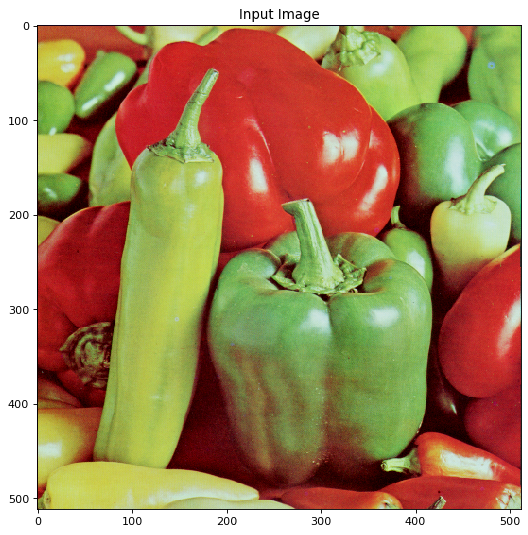

In [3]:
# STEP 0 Pick an image

# set image folder
image_folder = r'C:\Users\Metin\Desktop\EE421\Week6'

# read input image 
image_file = r'/peppers.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

# display image
my_display_actual_size(imgRGB,'Input Image')

In [4]:
# STEP 1 Transform the image into YUV color space

#---------------------------------------------------------------
# Extract the YUV bands of the image using "my_RGB2YUV()" function
#---------------------------------------------------------------

# ADD YOUR CODE BELOW

def my_RGB2YUV(imgRGB):
    
    N, M, D = imgRGB.shape
    
    assert N > 0
    assert M > 0
    assert D == 3
    
    # RGB to YUV conversion matrix    
    rgb2yuv = np.array([[0.299,    0.587,    0.114   ],
                       [-0.168736, -0.331264,  0.5   ],
                       [ 0.5,   -0.418688, -0.081312]])
        
    # convert from RGB to YUV
    imgYUV = np.dot(imgRGB, np.transpose(rgb2yuv))
    
    # add 128 to U and V bands
    imgYUV[:,:,1] += 128.0
    imgYUV[:,:,2] += 128.0
    
    return imgYUV

imgYUV = my_RGB2YUV(imgRGB)




In [5]:
def my_imgTruncate(img):
    
    img = np.round(img, 0)
    img = np.minimum(img, 255)
    img = np.maximum(img, 0)
    img = img.astype('uint8')
    
    return img

def my_RMSE(img1, img2):
    
    assert img1.ndim == img2.ndim
    assert img1.size == img2.size
    
    return math.sqrt(((img1 - img2)**2).sum() / img1.size)

def my_cubic_filter(n_filter):
    
    assert n_filter >= 1
    
    size_filter = n_filter * 4 - 1
    
    filter_cubic = np.zeros((size_filter,))
    
    filter_cubic[size_filter//2] = 1.0
    
    for i in range(1,n_filter):
        x = i/n_filter
        filter_cubic[size_filter//2 + i] = 1.0 - x**2

    for i in range(n_filter+1, n_filter*2):
        x = i/n_filter
        filter_cubic[size_filter//2 + i] = -2*(x-1)*(x-2)**2
    
    filter_cubic[:size_filter//2] = filter_cubic[-1:size_filter//2:-1]

    return filter_cubic

def my_YUV2RGB(imgYUV):
    
    N, M, D = imgYUV.shape
    
    assert N > 0
    assert M > 0
    assert D == 3
    
    # YUV to RGB conversion matrix
    yuv2rgb = np.array([[1.0,  0.0,       1.402   ],
                       [ 1.0, -0.344136, -0.714136],
                       [ 1.0,  1.772,     0.0    ]])
    
    # subtract 128 from U and V bands
    imgYUV_new = imgYUV.copy()
    imgYUV_new[:,:,1] -= 128.0
    imgYUV_new[:,:,2] -= 128.0

    # convert from YUV to RGB
    imgRGB = np.dot(imgYUV_new, np.transpose(yuv2rgb))
    
    imgRGB = np.round(imgRGB, 0)
    imgRGB = np.minimum(imgRGB, 255)
    imgRGB = np.maximum(imgRGB, 0)
    imgRGB = imgRGB.astype('uint8')
 
    return imgRGB



In [6]:
# STEP 2.a Demonstrate the effect of the Y band on image resolution

#---------------------------------------------------------------
# Decimate the Y band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# downsampling factor
n_down = 4

# set filter coefficients
my_filter = my_cubic_filter(n_down)
my_filter_2D = np.outer(my_filter,my_filter)


# low-pass (LP) filter image
img_dec = signal.convolve2d(imgYUV[:,:,0], my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_dec = my_imgTruncate(img_dec)

# downsample image
img_dec = img_dec[::n_down,::n_down]

#---------------------------------------------------------------
# Interpolate the decimated Y band back to its original size
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# upscaling factor
n_up = 4
height, width = img_dec.shape
img_up = np.zeros((height*n_up,width*n_up))
img_up[::n_up,::n_up] = img_dec


my_filter = my_cubic_filter(n_up)
my_filter_2D = np.outer(my_filter,my_filter)
# (note: there is no normalization of filter coefficients in the case of interpolation)

# 2D convolutionaaa
img_interp = signal.convolve2d(img_up, my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_interp = my_imgTruncate(img_interp)

imgYUV[:,:,0] = img_interp

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed Y band)
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
imgRGB_fromYUV_Y = my_YUV2RGB(imgYUV) 

#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
my_RMSE(imgRGB,imgRGB_fromYUV_Y)


10.467477051125385

In [7]:
# STEP 2.b Demonstrate the effect of the U band on image resolution

#---------------------------------------------------------------
# Decimate the U band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# downsampling factor
n_down = 4

# set filter coefficients
my_filter = my_cubic_filter(n_down)
my_filter_2D = np.outer(my_filter,my_filter)


# low-pass (LP) filter image
img_dec = signal.convolve2d(imgYUV[:,:,1], my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_dec = my_imgTruncate(img_dec)

# downsample image
img_dec = img_dec[::n_down,::n_down]

#---------------------------------------------------------------
# Interpolate the decimated Y band back to its original size
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# upscaling factor
n_up = 4
height, width = img_dec.shape
img_up = np.zeros((height*n_up,width*n_up))
img_up[::n_up,::n_up] = img_dec


my_filter = my_cubic_filter(n_up)
my_filter_2D = np.outer(my_filter,my_filter)
# (note: there is no normalization of filter coefficients in the case of interpolation)

# 2D convolutionaaa
img_interp = signal.convolve2d(img_up, my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_interp = my_imgTruncate(img_interp)

imgYUV[:,:,1] = img_interp

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed Y band)
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
imgRGB_fromYUV_U = my_YUV2RGB(imgYUV) 

#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
my_RMSE(imgRGB,imgRGB_fromYUV_U)


10.320094415986842

In [8]:
# STEP 2.c Demonstrate the effect of the V band on image resolution

#---------------------------------------------------------------
# Decimate the V band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# downsampling factor
n_down = 4

# set filter coefficients
my_filter = my_cubic_filter(n_down)
my_filter_2D = np.outer(my_filter,my_filter)


# low-pass (LP) filter image
img_dec = signal.convolve2d(imgYUV[:,:,2], my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_dec = my_imgTruncate(img_dec)

# downsample image
img_dec = img_dec[::n_down,::n_down]

#---------------------------------------------------------------
# Interpolate the decimated Y band back to its original size
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# upscaling factor
n_up = 4
height, width = img_dec.shape
img_up = np.zeros((height*n_up,width*n_up))
img_up[::n_up,::n_up] = img_dec


my_filter = my_cubic_filter(n_up)
my_filter_2D = np.outer(my_filter,my_filter)
# (note: there is no normalization of filter coefficients in the case of interpolation)

# 2D convolutionaaa
img_interp = signal.convolve2d(img_up, my_filter_2D, mode='same', boundary='fill', fillvalue=128)

# round to nearest integer
img_interp = my_imgTruncate(img_interp)

imgYUV[:,:,2] = img_interp

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed Y band)
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
imgRGB_fromYUV_V = my_YUV2RGB(imgYUV) 

#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
my_RMSE(imgRGB,imgRGB_fromYUV_V)


10.436763470945088

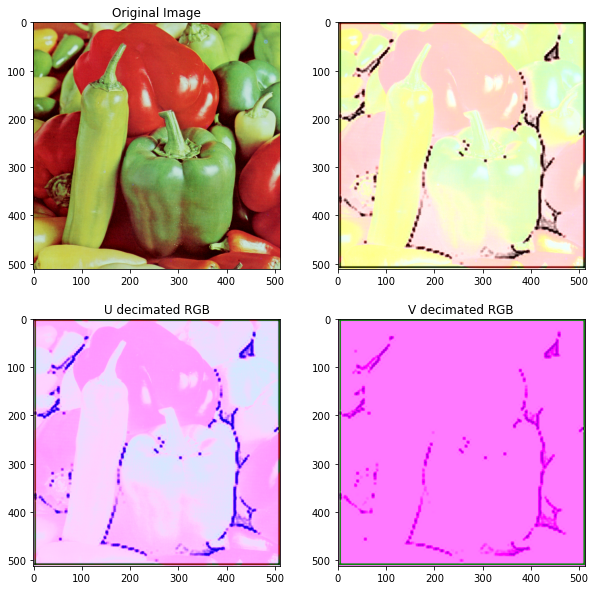

In [9]:
# STEP 3 Display the images obtained in STEP 2 above together with the original image

#---------------------------------------------------------------
# Display the original RGB image and the three RGB images obtained above in a 2x2 grid:
# [Original RGB]     [Y decimated RGB]
# [U decimated RGB]  [V decimated RGB]
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(imgRGB)
plt.title('Original Image')
plt.subplot(222), plt.imshow(imgRGB_fromYUV_Y)
plt.subplot(223), plt.imshow(imgRGB_fromYUV_U)
plt.title('U decimated RGB')
plt.subplot(224), plt.imshow(imgRGB_fromYUV_V)
plt.title('V decimated RGB')
plt.show()
plt.close()


*STEP 4 Comments on the results*

*ADD YOUR COMMENTS HERE*

Compare the three RGB images obtained in STEP 2 to the original RGB image in terms of (a) visual quality and (b) RMSE value and explain why decimation of different YUV bands have different effects on the RGB image quality.

a) Their spectrums are similare to each other. Actually I expect to see similar brightness of images.
b) RMS values are also depentent to spectrums the RMS values are nearly same to each other however the color is getting more contrasted.
